# West Main Corridor Analysis

In [1]:
import os
os.chdir(os.path.expanduser('geodata-py-utils'))
from geodata_py_utils import GeoData, InputTypes
import pandas as pd
import json
import matplotlib as plt
import warnings

warnings.filterwarnings('ignore')

#### Change dir to kzoo data

In [2]:
os.chdir('/home/pi/dev/notebooks/kzoo_streetlight/data/kzoo_street_12225')
dirs = os.listdir()
os.chdir(dirs[0])
os.getcwd()

'/home/pi/dev/notebooks/kzoo_streetlight/data/kzoo_street_12225/1861928_West_Main_Street'

#### Create pandas dataframe from west main traffic data

In [3]:
files = os.listdir()
df = pd.read_csv(files[0])
df.head(3)

,Data Periods,Mode of Travel,Zone ID,Zone Name,Road Classification,Line Zone Length (Miles),Zone Is Pass Through,Zone Direction (degrees),Zone Cardinal Direction,Zone is Bi-Direction,Day Type,Day Part,Average Daily Segment Traffic (StL Volume),Avg Segment Speed (mph),Avg Segment Travel Time (sec),Free Flow Speed (mph),Vehicle Miles of Travel (StL Volume),Travel Time Index,Congested Segment,85th Speed Percentile
0,"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0: All Days (M-Su),00: All Day (12am-12am),11509,40,3,44.303,360.04,1.12,False,45
1,"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0: All Days (M-Su),01: 12am (12am-1am),125,40,3,44.303,3.92,1.09,False,46
2,"Jan 01, 2022 - Dec 31, 2023",All Vehicles - StL All Vehicles Volume,1111503841,West Main Street / 111568112 / 7,Primary,0.031,yes,92,EAST,yes,0: All Days (M-Su),02: Early AM (12am-6am),469,41,3,44.303,14.68,1.07,False,47


#### Filter to retain only 1 summary traffic count per segement

In [4]:
df_all = df[(df['Day Part'] == '00: All Day (12am-12am)') & (df['Day Type'] == '0: All Days (M-Su)')]
c = df_all.columns
df_at = df_all[[c[2], c[5], c[10], c[12], c[13], c[15], c[19]]]
df_at.count()

Zone ID                                       53
Line Zone Length (Miles)                      53
Day Type                                      53
Average Daily Segment Traffic (StL Volume)    53
Avg Segment Speed (mph)                       53
Free Flow Speed (mph)                         53
85th Speed Percentile                         53
dtype: int64

Set index for traffic dataframe as Zone ID for join

In [5]:
df_at.set_index(df_at['Zone ID'], inplace=True)
data = df_at.to_dict('index')
data[1111503841]

{'Zone ID': 1111503841,
 'Line Zone Length (Miles)': 0.031,
 'Day Type': '0: All Days (M-Su)',
 'Average Daily Segment Traffic (StL Volume)': 11509,
 'Avg Segment Speed (mph)': 40,
 'Free Flow Speed (mph)': 44.303,
 '85th Speed Percentile': 45}

### Testing GeoData Lib Section

Load west_main geojson using GeoData library

In [6]:
file_path = '/home/pi/dev/notebooks/kzoo_streetlight/data/kzoo_street_12225/1861928_West_Main_Street/west_main.geojson'
geo_data = GeoData(file_path, InputTypes.DATA_PATH)
geo_data.gdf.head(3)

,segment_id,name,segment_ty,geometry
0,1111503841,West Main Street / 111568112 / 7,primary,"LINESTRING (-85.61777 42.29486, -85.61716 42.2..."
1,1111754274,West Main Street / 727695179 / 1,primary,"LINESTRING (-85.62555 42.2955, -85.62523 42.29..."
2,1111871475,West Main Street / 264373332 / 7,primary,"LINESTRING (-85.63055 42.29619, -85.62977 42.2..."


Join traffic data to segments using Zone ID/ segment_id

In [7]:
new_gj = {'type': 'FeatureCollection', 'features': []}
for f in geo_data.geojson['features']:
    f['properties'].update(data[f['properties']['segment_id']])
    new_gj['features'].append(f)
new_gj['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'segment_id': 1111503841,
  'name': 'West Main Street / 111568112 / 7',
  'segment_ty': 'primary',
  'Zone ID': 1111503841,
  'Line Zone Length (Miles)': 0.031,
  'Day Type': '0: All Days (M-Su)',
  'Average Daily Segment Traffic (StL Volume)': 11509,
  'Avg Segment Speed (mph)': 40,
  'Free Flow Speed (mph)': 44.303,
  '85th Speed Percentile': 45},
 'geometry': {'type': 'LineString',
  'coordinates': [[-85.61777353286743, 42.29485583305359],
   [-85.61715984344482, 42.29484176635742]]}}

In [8]:
geo_data_join = GeoData(new_gj, InputTypes.DATA_FEATURES)
geo_data_join.geojson['features'][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'segment_id': 1111503841,
  'name': 'West Main Street / 111568112 / 7',
  'segment_ty': 'primary',
  'Zone ID': 1111503841,
  'Line Zone Length (Miles)': 0.031,
  'Day Type': '0: All Days (M-Su)',
  'Average Daily Segment Traffic (StL Volume)': 11509,
  'Avg Segment Speed (mph)': 40,
  'Free Flow Speed (mph)': 44.303,
  '85th Speed Percentile': 45},
 'geometry': {'type': 'LineString',
  'coordinates': [[-85.61777353286743, 42.29485583305359],
   [-85.61715984344482, 42.29484176635742]]}}

In [9]:
os.chdir('/home/pi/dev/notebooks/kzoo_streetlight/data')
geo_data_join.export_geojson('west_main_joined')

GeoJSON output: west_main_joined.geojson


## Summary Stats & Plots

In [11]:
dfc = df.copy(deep=True)
dfc.rename(columns={'Average Daily Segment Traffic (StL Volume)': 'Avg Daily Seg Traffic ', \
                    'Avg Segment Speed (mph)': 'Avg Seg Spd (mph)', 
                    '85th Speed Percentile': '85th Spd PCTL', 
                    'Line Zone Length (Miles)': 'Zone Length (mi)', 
                    'Free Flow Speed (mph)': 'Free Flow Spd (mph)' }, inplace=True)
dc = dfc.columns
print([(i, item) for i, item in enumerate(dc)]) 

[(0, 'Data Periods'), (1, 'Mode of Travel'), (2, 'Zone ID'), (3, 'Zone Name'), (4, 'Road Classification'), (5, 'Zone Length (mi)'), (6, 'Zone Is Pass Through'), (7, 'Zone Direction (degrees)'), (8, 'Zone Cardinal Direction'), (9, 'Zone is Bi-Direction'), (10, 'Day Type'), (11, 'Day Part'), (12, 'Avg Daily Seg Traffic '), (13, 'Avg Seg Spd (mph)'), (14, 'Avg Segment Travel Time (sec)'), (15, 'Free Flow Spd (mph)'), (16, 'Vehicle Miles of Travel (StL Volume)'), (17, 'Travel Time Index'), (18, 'Congested Segment'), (19, '85th Spd PCTL')]


In [12]:
dfc[[dc[5], dc[12], dc[13],dc[15],dc[19]]].describe().T.drop(columns=['25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main All Segments/Entries Stats</h3>') \
  .relabel_index([f'<b>{dc[5]}<br>',f'<b>{dc[12]}<br>',f'<b>{dc[13]}<br>',f'<b>{dc[15]}<br>',f'<b>{dc[19]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,COUNT,MEAN,STD,MIN,MAX
Zone Length (mi),"4,770.00",0.07,0.05,0.01,0.29
Avg Daily Seg Traffic,"4,770.00","1,212.85","2,299.47",21.00,"17,452.00"
Avg Seg Spd (mph),"4,770.00",37.67,4.44,19.00,46.00
Free Flow Spd (mph),"4,770.00",43.24,3.76,21.80,47.42
85th Spd PCTL,"4,770.00",45.18,3.20,30.00,53.00


In [13]:
df_atc = df_at.copy(deep=True)
df_atc.rename(columns={'Average Daily Segment Traffic (StL Volume)': 'Avg Daily Seg Traffic ', \
                    'Avg Segment Speed (mph)': 'Avg Seg Spd (mph)', 
                    '85th Speed Percentile': '85th Spd PCTL', 
                    'Line Zone Length (Miles)': 'Zone Length (mi)', 
                    'Free Flow Speed (mph)': 'Free Flow Spd (mph)' }, inplace=True)
dc = df_atc.columns
print([(i, item) for i, item in enumerate(dc)]) 

[(0, 'Zone ID'), (1, 'Zone Length (mi)'), (2, 'Day Type'), (3, 'Avg Daily Seg Traffic '), (4, 'Avg Seg Spd (mph)'), (5, 'Free Flow Spd (mph)'), (6, '85th Spd PCTL')]


In [15]:
df_atc[[dc[1], dc[3], dc[4], dc[5], dc[6]]].describe().T.drop(columns=['count', '25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main All Seg - All Days (M-Su) - Stats</h2>') \
  .relabel_index([f'<b>{dc[1]}<br>',f'<b>{dc[3]}<br>',f'<b>{dc[4]}<br>',f'<b>{dc[5]}<br>',f'<b>{dc[6]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,MEAN,STD,MIN,MAX
Zone Length (mi),0.07,0.05,0.01,0.29
Avg Daily Seg Traffic,"12,565.70","1,747.09","9,173.00","16,557.00"
Avg Seg Spd (mph),36.66,4.22,19.00,43.00
Free Flow Spd (mph),43.24,3.80,21.80,47.42
85th Spd PCTL,44.55,2.93,32.00,50.00


In [16]:
seq = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
      'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 
      'PuBuGn', 'BuGn', 'YlGn']
seq2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 
       'summer', 'autumn', 'winter', 'cool','Wistia', 'hot', 'afmhot', 
       'gist_heat', 'copper']
uni = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'Wistia', 'PiYG']
unir = ['viridis_r', 'plasma_r', 'inferno_r', 'magma_r', 'cividis_r', 'cool_r', 'Wistia_r']
div = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 
       'Spectral', 'coolwarm', 'bwr', 'seismic']
divr = ['PiYG_r', 'PRGn_r', 'BrBG_r', 'PuOr_r', 'RdGy_r', 'RdBu_r', 'RdYlBu_r', 
        'RdYlGn_r', 'Spectral_r', 'coolwarm_r', 'bwr_r', 'seismic_r']

In [24]:
z = 0
df_atc.drop(columns=['Zone ID' , 'Day Type']).style \
.set_table_styles([
    {"selector": "th", "props": [("width", "70px")]}, 
    {"selector": "tr", "props": [("color", "white"), ("text-align", "center")]},
    ]) \
.format().bar(subset=['Avg Daily Seg Traffic '], cmap=f'Blues', props="opacity: 0.7;", vmin=9173, vmax=16557, width=60, align='left') \
.format().bar(subset=['Zone Length (mi)'], cmap=f'{seq[0]}', props="opacity: 0.7;", vmin=0.01, vmax=0.29, width=60, align='left') \
.format().bar(subset=['Avg Seg Spd (mph)'], cmap=f'{uni[z]}', props="opacity: 0.8;", vmin=19, vmax=47.42, width=60, align='left') \
.format().bar(subset=['Free Flow Spd (mph)'], cmap=f'{uni[z]}', props="opacity: 0.8;", vmin=19, vmax=47.42, width=60, align='left') \
.format(precision=2, thousands=",", decimal=".") 

,Zone Length (mi),Avg Daily Seg Traffic,Avg Seg Spd (mph),Free Flow Spd (mph),85th Spd PCTL
Zone ID,,,,,
1111503841,0.03,"11,509",40,44.30,45
1111754274,0.02,"11,450",37,42.52,43
1111871475,0.06,"12,575",34,43.48,45
1112032394,0.03,"11,558",39,44.12,45
1112161013,0.19,"16,557",33,44.30,45
1112668374,0.03,"11,473",38,43.47,44
1112849422,0.05,"11,463",33,39.88,42
1113019695,0.02,"11,408",39,44.84,46
1113040226,0.06,"12,398",37,43.79,44


#### Removing Outlier Summary

In [25]:
df_atc_o = df_atc.copy(deep=True) 

std = df_atc_o['Free Flow Spd (mph)'].std()
mean = df_atc_o['Free Flow Spd (mph)'].mean()
df_atc_o = df_atc_o[(df_atc_o['Free Flow Spd (mph)'] >= mean - std*2) & (df_atc_o['Free Flow Spd (mph)'] <= mean + std*2)  ]
df_atc_o['Free Flow Spd (mph)'].min()

np.float64(38.562)

In [26]:
df_atc_o[[dc[1], dc[3], dc[4], dc[5], dc[6]]].describe().T.drop(columns=['count', '25%', '50%', '75%']).style \
  .format(precision=2, thousands=",", decimal=".") \
  .format_index(str.upper, axis=1) \
  .set_caption('<h2>West Main All Seg - All Days (M-Su) - Stats</h2>') \
  .relabel_index([f'<b>{dc[1]}<br>',f'<b>{dc[3]}<br>',f'<b>{dc[4]}<br>',f'<b>{dc[5]}<br>',f'<b>{dc[6]}<br>'], axis=0) \
  .set_table_styles([{"selector": "tr", "props": [("height", "36px")]}]) 

,MEAN,STD,MIN,MAX
Zone Length (mi),0.07,0.06,0.01,0.29
Avg Daily Seg Traffic,"12,453.27","1,683.08","9,173.00","16,557.00"
Avg Seg Spd (mph),37.20,3.19,27.00,43.00
Free Flow Spd (mph),43.87,1.81,38.56,47.42
85th Spd PCTL,44.94,2.11,39.00,50.00


In [94]:
import matplotlib.colors as mcolors  # To convert color names to RGB
import colorsys  # For HSL color adjustments
def bar_with_opacity(val: float, vmin: float, vmax: float, color: str, opacity: float):
    norm_val = (val - vmin) / (vmax - vmin) * 100  # Normalize to percentage
    rgb = mcolors.to_rgb(color)  # Returns (R, G, B) values in 0-1 scale
    rgb_str = f"{int(rgb[0]*255)}, {int(rgb[1]*255)}, {int(rgb[2]*255)}"  # Convert to 0-255 scale
    # print(rgb_str, norm_val*.01)
    return f'background: linear-gradient(90deg, rgba({rgb_str}, {norm_val*.01*opacity}) {norm_val}%, transparent {norm_val}%);'

In [ ]:
import matplotlib.cm as cm  
def bar_with_colormap(val: int | float, vmin: int | float, vmax: int | float, cmap_name: str, opacity: float=1.0, wdth: int=100 ) -> str:
    norm = (val - vmin) / (vmax - vmin)  
    colormap = cm.get_cmap(cmap_name)  
    rgba = colormap(norm)  
    rgb_str = f"{int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}"
    styles = []
    bar_style = f'background: linear-gradient(90deg, rgba({rgb_str}, {opacity}) {norm*wdth}%, transparent {norm*wdth}%); border: 1px solid rgba(100, 100, 100, .6);'
    # return f'background: linear-gradient(90deg, rgba({rgb_str}, {opacity}) {norm*wdth}%, transparent {norm*wdth}%); borde-right: 1px solid rgba(100, 100, 100, .6);'
    styles.append(bar_style)
    return bar_style

In [172]:
z, a, w, s = 0, 0.5, 60, 2
df_atc_o.drop(columns=['Zone ID' , 'Day Type']).style \
.set_table_styles([
    {"selector": "th", "props": [("width", "100px"), ("text-align", "center")]}, 
    {"selector": "tr", "props": [("color", "white"), ("text-align", "center")]},
    # {"selector": "", "props": [("border", "1px solid")]} 
     ]) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[6]].min()-s, 
            vmax=df_atc_o[dc[6]].max(), 
            cmap_name=f'{uni[0]}', 
            opacity=a, 
            wdth=w), 
        subset=['85th Spd PCTL']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[5]].min()-s, 
            vmax=df_atc_o[dc[5]].max(), 
            cmap_name=uni[z], 
            opacity=a, 
            wdth=w), 
        subset=['Free Flow Spd (mph)']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[4]].min()-s, 
            vmax=df_atc_o[dc[4]].max(), 
            cmap_name=uni[z], 
            opacity=a, 
            wdth=w), 
        subset=['Avg Seg Spd (mph)']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[3]].min()-200, 
            vmax=df_atc_o[dc[3]].max(), 
            cmap_name=seq[2], 
            opacity=a, 
            wdth=w), 
        subset=['Avg Daily Seg Traffic ']) \
        .applymap(lambda x: bar_with_colormap(
            val=x, 
            vmin=df_atc_o[dc[1]].min()-.02, 
            vmax=df_atc_o[dc[1]].max(), 
            cmap_name=f'{seq[0]}', 
            opacity=1.0, 
            wdth=w), 
        subset=['Zone Length (mi)']) \
.format(precision=2, thousands=",", decimal=".")
# .format().bar(subset=['Zone Length (mi)'], cmap=f'{seq[0]}', props="opacity: 0.7;", vmin=0.01, vmax=0.29, width=60, align='left') \

,Zone Length (mi),Avg Daily Seg Traffic,Avg Seg Spd (mph),Free Flow Spd (mph),85th Spd PCTL
Zone ID,,,,,
1111503841,0.03,"11,509",40,44.30,45
1111754274,0.02,"11,450",37,42.52,43
1111871475,0.06,"12,575",34,43.48,45
1112032394,0.03,"11,558",39,44.12,45
1112161013,0.19,"16,557",33,44.30,45
1112668374,0.03,"11,473",38,43.47,44
1112849422,0.05,"11,463",33,39.88,42
1113019695,0.02,"11,408",39,44.84,46
1113040226,0.06,"12,398",37,43.79,44


In [109]:
dc

Index(['Zone ID', 'Zone Length (mi)', 'Day Type', 'Avg Daily Seg Traffic ',
       'Avg Seg Spd (mph)', 'Free Flow Spd (mph)', '85th Spd PCTL'],
      dtype='object')

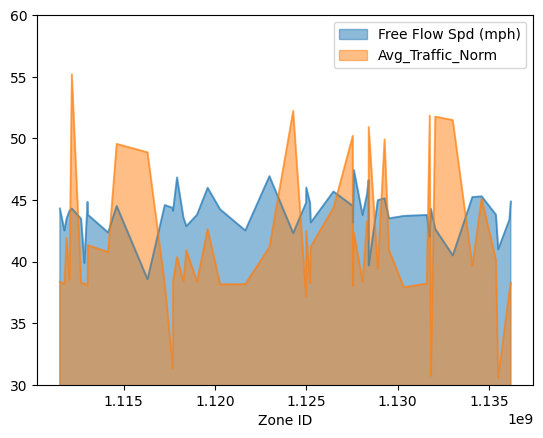

In [ ]:
df_atc_o_area = df_atc_o.copy(deep=True)
df_atc_o_area['Avg_Traffic_Norm'] = df_atc_o_area['Avg Daily Seg Traffic '].apply(lambda x: x/300)
# df_atc_o.drop(columns=['Zone ID' , 'Day Type', 'Avg Daily Seg Traffic ', 'Zone Length (mi)']).plot.area(stacked=False);
ax = df_atc_o_area.drop(columns=['Zone ID' , 'Day Type', 'Avg Daily Seg Traffic ', 'Zone Length (mi)', 'Avg Seg Spd (mph)', '85th Spd PCTL']) \
    .plot.area(stacked=False, )
ax.set_ylim(30, 60);


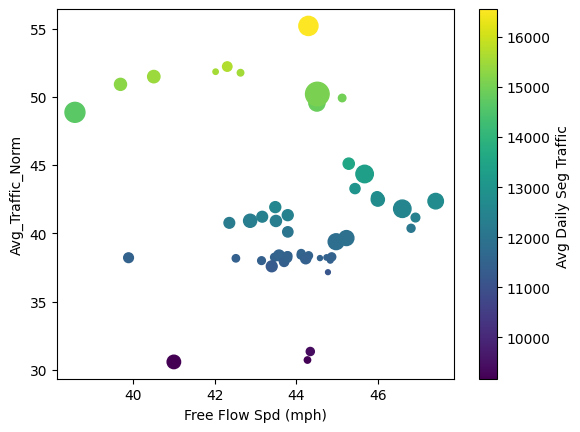

In [222]:
df_atc_o_area['Avg_Traffic_Norm'] = df_atc_o_area['Avg Daily Seg Traffic '].apply(lambda x: x/300)
df_atc_o_area['Zone_Length_Norm'] = df_atc_o_area['Zone Length (mi)'].apply(lambda x: x*1000)
df_atc_o_area['Avg_Traffic_Plot'] = df_atc_o_area['Avg_Traffic_Norm'].apply(lambda x: x*5)
df_atc_o_area['85th_Norm'] = df_atc_o_area['85th Spd PCTL'].apply(lambda x: x*100)
df_atc_o_area.plot.scatter(y='Avg_Traffic_Norm', x="Free Flow Spd (mph)", s='Zone_Length_Norm', c='Avg Daily Seg Traffic ', cmap="viridis");

In [189]:
df_atc_o_area['Avg_Traffic_Norm'].describe()

count    51.000000
mean     41.510915
std       5.610279
min      30.576667
25%      38.208333
50%      40.103333
75%      42.953333
max      55.190000
Name: Avg_Traffic_Norm, dtype: float64

In [29]:
seq = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
      'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 
      'PuBuGn', 'BuGn', 'YlGn']
seq2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 
       'summer', 'autumn', 'winter', 'cool','Wistia', 'hot', 'afmhot', 
       'gist_heat', 'copper']
uni = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'Wistia', 'PiYG']
unir = ['viridis_r', 'plasma_r', 'inferno_r', 'magma_r', 'cividis_r', 'cool_r', 'Wistia_r']
div = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 
       'Spectral', 'coolwarm', 'bwr', 'seismic']
divr = ['PiYG_r', 'PRGn_r', 'BrBG_r', 'PuOr_r', 'RdGy_r', 'RdBu_r', 'RdYlBu_r', 
        'RdYlGn_r', 'Spectral_r', 'coolwarm_r', 'bwr_r', 'seismic_r']